### Introduction

The objective of this exercise is to construct multiple models capable of accurately predicting the total price of taxi fares. To begin, a basic multiple regression model will be developed. Afterwards, a random forest model will be created to see if we can do better. Finally, an Artificial Neural Network (ANN) will be implemented. ANNs are mathematical models designed to replicate the information processing capabilities of the human brain. By utilizing these models, I aim to achieve robust and precise predictions of taxi fares.


The dataset comes from Kaggle:
https://www.kaggle.com/datasets/nani123456789/taxi-trip-fare-prediction/data

### Question I seek to answer
Given that there are two passengers on a trip with a trip duration of 100 minutes, a distance traveled of 5 miles, a tip of $10, and miscellaneous fees of $5, what will be their total fare?

### Import libraries

In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

sns.set()
pd.options.display.float_format = '{:,.4f}'.format

### Import dataset

In [157]:
data = pd.read_csv('fare.csv')
data.head()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
0,748,2.7500,1,75.0000,24,6.3000,105.3000,0
1,1187,3.4300,1,105.0000,24,13.2000,142.2000,0
2,730,3.1200,1,71.2500,0,26.6250,97.8750,1
3,671,5.6300,3,90.0000,0,9.7500,99.7500,0
4,329,2.0900,1,45.0000,12,13.2000,70.2000,0


In [158]:
data.shape

(209673, 8)

In [159]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209673 entries, 0 to 209672
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   trip_duration       209673 non-null  int64  
 1   distance_traveled   209673 non-null  float64
 2   num_of_passengers   209673 non-null  int64  
 3   fare                209673 non-null  float64
 4   tip                 209673 non-null  int64  
 5   miscellaneous_fees  209673 non-null  float64
 6   total_fare          209673 non-null  float64
 7   surge_applied       209673 non-null  int64  
dtypes: float64(4), int64(4)
memory usage: 12.8 MB


In [160]:
data.describe()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
count,"209,673.0000","209,673.0000","209,673.0000","209,673.0000","209,673.0000","209,673.0000","209,673.0000","209,673.0000"
mean,"1,173.1815",5.0544,1.2928,99.6234,13.0308,15.1368,127.7911,0.2805
std,"4,775.6536",125.2174,0.9308,85.6027,20.3678,12.5534,98.7974,0.4493
min,0.0000,0.0200,0.0000,0.0000,0.0000,-0.5000,0.0000,0.0000
25%,446.0000,1.9500,1.0000,52.5000,0.0000,6.0000,70.2000,0.0000
50%,707.0000,3.2000,1.0000,75.0000,9.0000,9.7500,101.7000,0.0000
75%,"1,098.0000",5.7300,1.0000,116.2500,20.0000,26.4500,152.2500,1.0000
max,"86,387.0000","57,283.9100",9.0000,"4,466.2500","2,500.0000",435.0000,"4,472.2500",1.0000


#### Any nan values

In [161]:
data_nan = data.isna().values.sum()
data_nan

0

The dataset does not have missing values.

#### Any duplicates

In [162]:
data_dup = data.duplicated().values.sum()
print(data_dup)

4325


In [163]:
data1 = data.drop_duplicates()
data1.head()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
0,748,2.7500,1,75.0000,24,6.3000,105.3000,0
1,1187,3.4300,1,105.0000,24,13.2000,142.2000,0
2,730,3.1200,1,71.2500,0,26.6250,97.8750,1
3,671,5.6300,3,90.0000,0,9.7500,99.7500,0
4,329,2.0900,1,45.0000,12,13.2000,70.2000,0


We have 4325 duplicate values. We can drop these values.

### Displot

The goal of the displot is to ensure the dataset is normally distributed. This is very important in prediction.

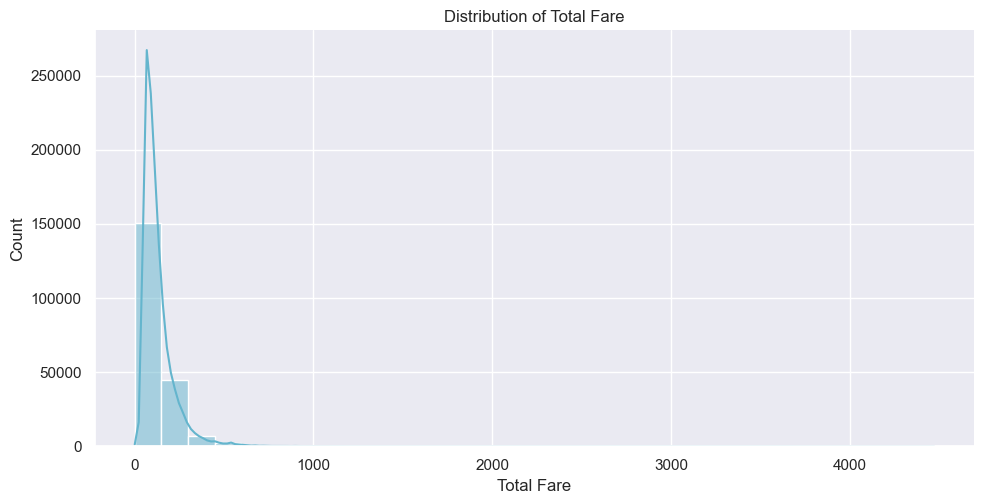

In [164]:
import warnings
warnings.filterwarnings('ignore')

# Total fare

sns.displot(data1['total_fare'],
             bins=30,
             aspect = 2,
             kde=True,
             color='c'
)

plt.title('Distribution of Total Fare')
plt.xlabel('Total Fare')
plt.show()

The dataset has outliers that need to be taken care of.

### Dealing with outliers

In [165]:
q = data1['total_fare'].quantile(0.90)
q

229.95

Based on the distribution of the data, considering the lowest 90 percent of the data is good. A total fare of 229.95 is realistic.

In [167]:
data1 = data[data['total_fare'] < q]
data1.describe()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
count,"188,937.0000","188,937.0000","188,937.0000","188,937.0000","188,937.0000","188,937.0000","188,937.0000","188,937.0000"
mean,"1,002.2417",3.6484,1.2892,80.3135,10.3908,13.7015,104.4057,0.2586
std,"4,521.8601",3.7253,0.9331,38.3376,11.9180,9.9911,46.3492,0.4378
min,0.0000,0.0200,0.0000,0.0000,0.0000,-0.5000,0.0000,0.0000
25%,424.0000,1.8500,1.0000,52.5000,0.0000,6.0000,69.7500,0.0000
50%,655.0000,2.9100,1.0000,71.2500,8.0000,9.7500,94.9500,0.0000
75%,961.0000,4.7200,1.0000,101.2500,18.0000,26.2000,133.5000,1.0000
max,"86,384.0000","1,136.5000",9.0000,225.6750,225.0000,111.7500,229.8750,1.0000


We can now visualize the data.

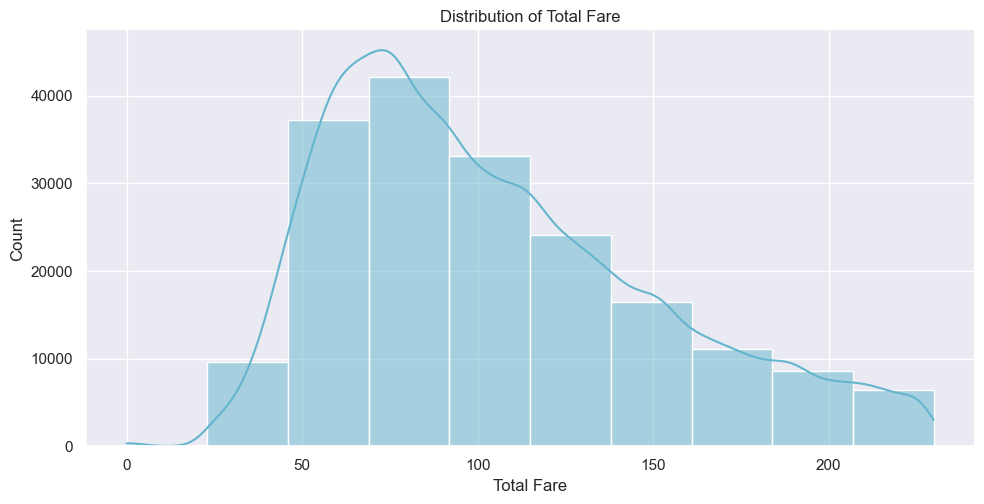

In [168]:
import warnings
warnings.filterwarnings('ignore')

sns.displot(data1['total_fare'],
             bins=10,
             aspect = 2,
             kde=True,
             color='c'
)

plt.title('Distribution of Total Fare')
plt.xlabel('Total Fare')
plt.show()

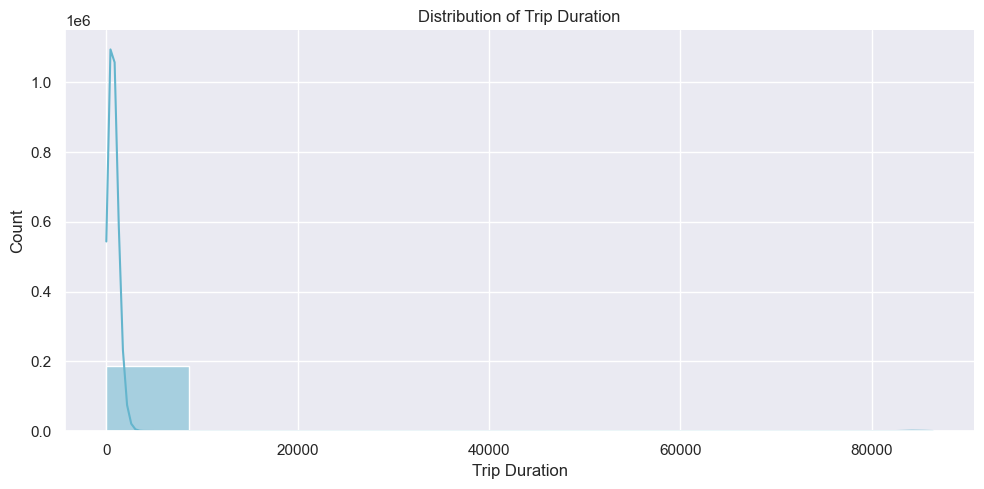

In [169]:
# Trip Duration
sns.displot(data1['trip_duration'],
             bins=10,
             aspect = 2,
             kde=True,
             color='c'
)

plt.title('Distribution of Trip Duration')
plt.xlabel('Trip Duration')
plt.show()

Similar to the total fare column, we can try to normalize the distribution.

In [173]:
q1 = data1['trip_duration'].quantile(0.90)
q1

1327.0

In [174]:
data2 = data1[data1['trip_duration']<q1]
data2.describe()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
count,"170,005.0000","170,005.0000","170,005.0000","170,005.0000","170,005.0000","170,005.0000","170,005.0000","170,005.0000"
mean,634.5002,3.2566,1.2879,72.8304,10.1530,13.3055,96.2889,0.2385
std,302.3018,3.5243,0.9336,31.0771,11.3736,9.8190,39.8720,0.4262
min,0.0000,0.0200,0.0000,0.0000,0.0000,-0.5000,0.0000,0.0000
25%,400.0000,1.7700,1.0000,48.7500,0.0000,6.0000,66.0000,0.0000
50%,607.0000,2.6900,1.0000,67.5000,8.0000,9.7500,88.5000,0.0000
75%,851.0000,4.1200,1.0000,90.0000,18.0000,13.9500,120.0750,0.0000
max,"1,326.0000","1,136.5000",9.0000,225.6750,225.0000,111.7500,229.8750,1.0000


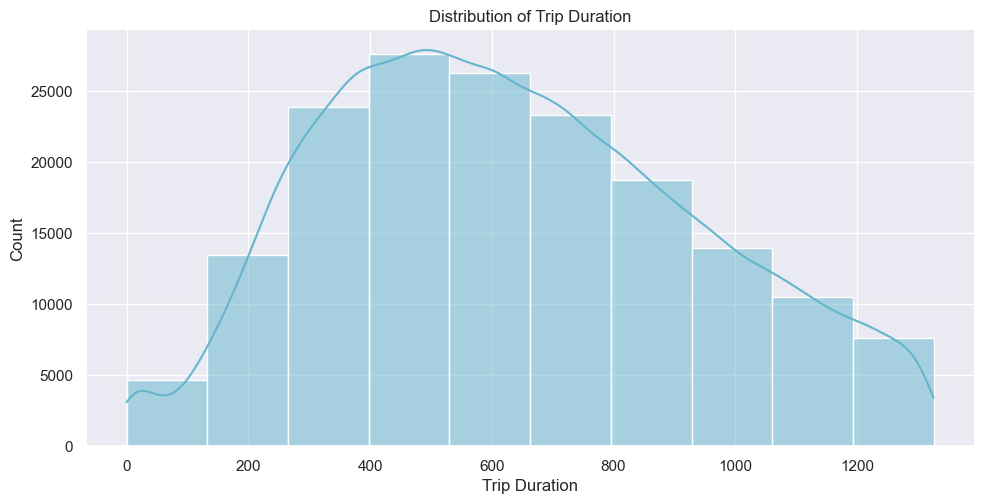

In [175]:
sns.displot(data2['trip_duration'],
             bins=10,
             aspect = 2,
             kde=True,
             color='c'
)

plt.title('Distribution of Trip Duration')
plt.xlabel('Trip Duration')
plt.show()

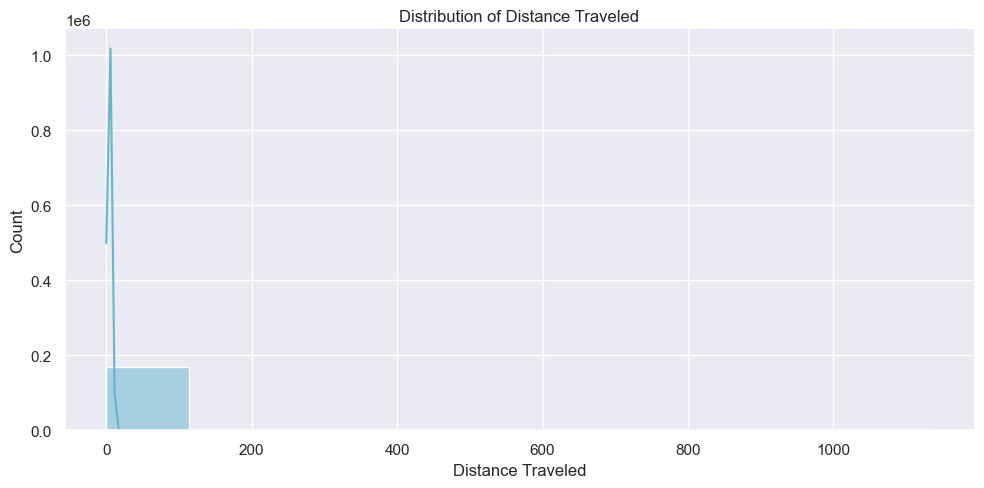

In [178]:
sns.displot(data2['distance_traveled'],
             bins=10,
             aspect = 2,
             kde=True,
             color='c'
)

plt.title('Distribution of Distance Traveled')
plt.xlabel('Distance Traveled')
plt.show()

In [176]:
q2 = data2['distance_traveled'].quantile(0.9)
q2

6.08

In [177]:
data3 = data2[data2['distance_traveled'] < q2]
data3.describe()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
count,"152,919.0000","152,919.0000","152,919.0000","152,919.0000","152,919.0000","152,919.0000","152,919.0000","152,919.0000"
mean,596.5693,2.6867,1.2851,66.1668,9.5359,12.8258,88.5285,0.2216
std,285.9151,1.3444,0.9317,23.7329,10.6210,9.3464,32.4812,0.4153
min,0.0000,0.0200,0.0000,0.0000,0.0000,-0.5000,0.0000,0.0000
25%,379.0000,1.6600,1.0000,48.7500,0.0000,6.0000,63.7500,0.0000
50%,567.0000,2.4800,1.0000,63.7500,8.0000,9.7000,83.7000,0.0000
75%,791.0000,3.5900,1.0000,82.5000,17.0000,13.7000,110.7000,0.0000
max,"1,326.0000",6.0700,9.0000,225.0000,225.0000,111.7500,228.9000,1.0000


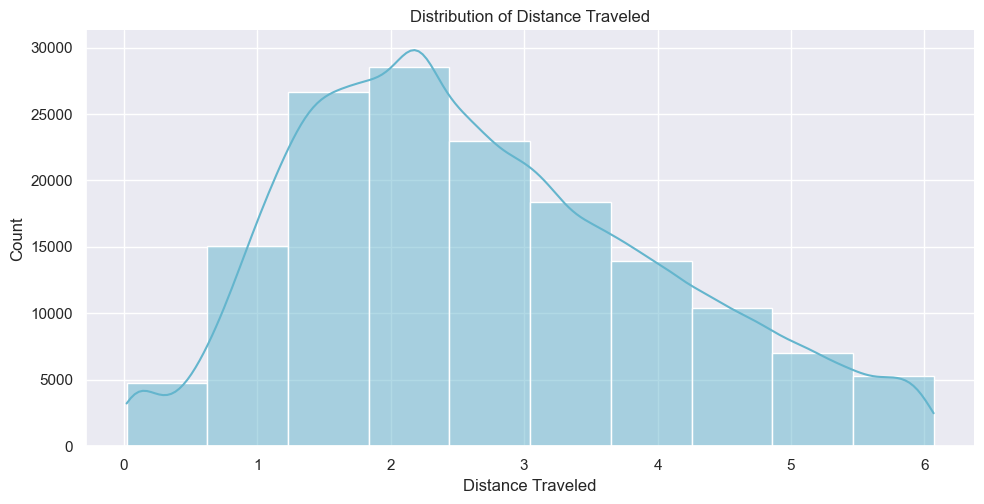

In [21]:
sns.displot(data3['distance_traveled'],
             bins=10,
             aspect = 2,
             kde=True,
             color='c'
)

plt.title('Distribution of Distance Traveled')
plt.xlabel('Distance Traveled')
plt.show()

The data looks normally distributed now.

### Pairplots with regression lines

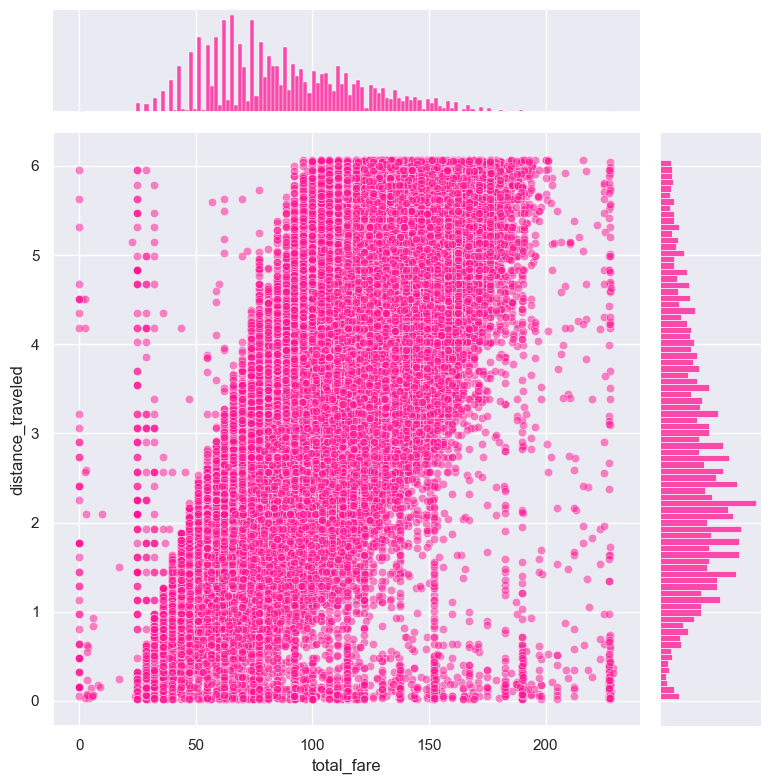

In [22]:
sns.jointplot(x=data3['total_fare'], 
                y=data3['distance_traveled'], 
                height=8, 
                kind='scatter',
                color='deeppink', 
                joint_kws={'alpha':0.5})

plt.show()

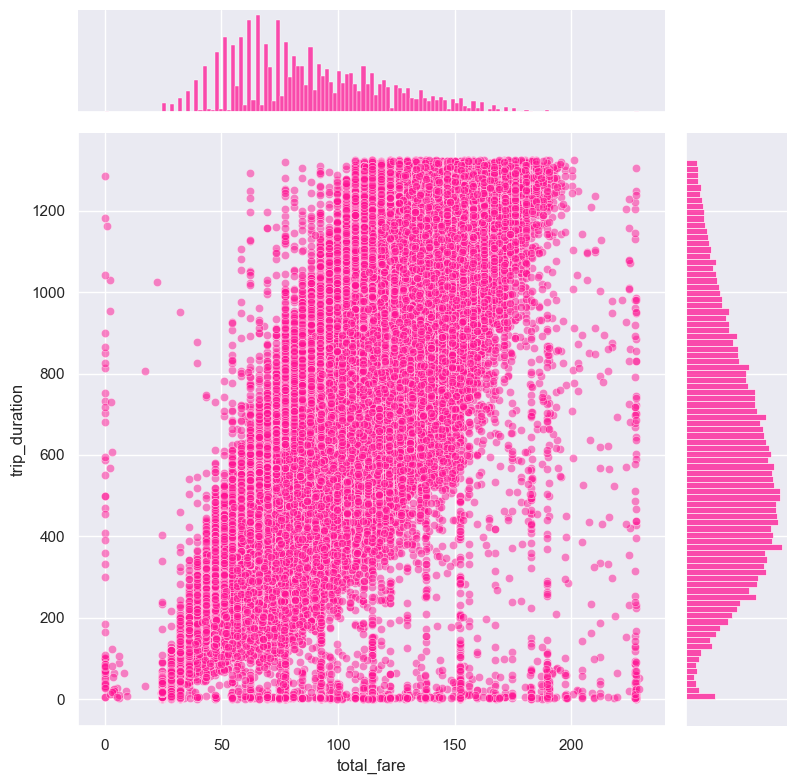

In [23]:
sns.jointplot(x=data3['total_fare'], 
                y=data3['trip_duration'], 
                height=8, 
                kind='scatter',
                color='deeppink', 
                joint_kws={'alpha':0.5})

plt.show()

### Box Plot

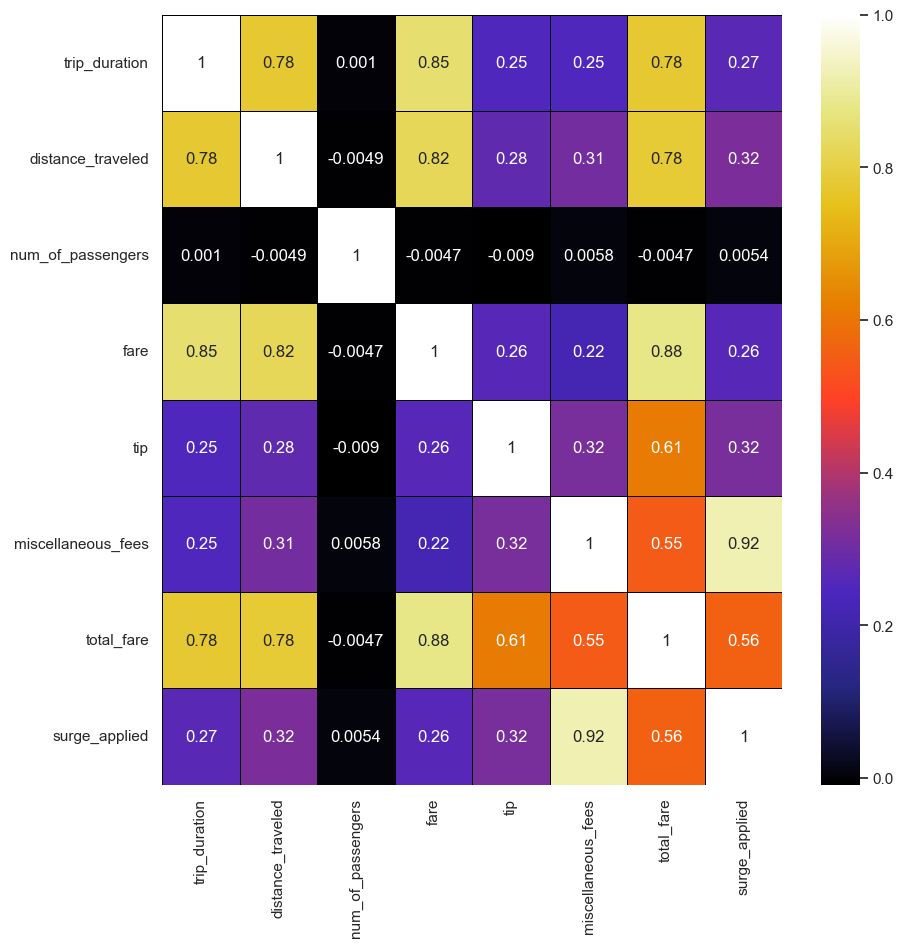

In [24]:
plt.figure(figsize=(10,10))
sns.heatmap(data3.corr(), cmap='CMRmap', linecolor='black', linewidths=0.5, annot=True)
plt.show()

In [41]:
# Create a checkpoint
df = data3.copy()

### Drop two columns

We can drop the fare and surge_applied columns. Fare is similar to the total_fare. surge_applied doesn't affect the final result.

In [42]:
df = df.drop(['fare', 'surge_applied'], axis=1)
df.head()

,trip_duration,distance_traveled,num_of_passengers,tip,miscellaneous_fees,total_fare
0,748,2.7500,1,24,6.3000,105.3000
1,1187,3.4300,1,24,13.2000,142.2000
2,730,3.1200,1,0,26.6250,97.8750
3,671,5.6300,3,0,9.7500,99.7500
4,329,2.0900,1,12,13.2000,70.2000


### Create the inputs and targets

In [43]:
x = df.drop(['total_fare'], axis=1)
x.head()

,trip_duration,distance_traveled,num_of_passengers,tip,miscellaneous_fees
0,748,2.7500,1,24,6.3000
1,1187,3.4300,1,24,13.2000
2,730,3.1200,1,0,26.6250
3,671,5.6300,3,0,9.7500
4,329,2.0900,1,12,13.2000


In [44]:
y = df['total_fare']
y.head()

0   105.3000
1   142.2000
2    97.8750
3    99.7500
4    70.2000
Name: total_fare, dtype: float64

### Scale data

In [45]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x_scaled

array([[ 0.529637  ,  0.04711929, -0.30594352,  1.3618408 , -0.69820933],
       [ 2.06506302,  0.55292509, -0.30594352,  1.3618408 ,  0.04004185],
       [ 0.46668104,  0.32233715, -0.30594352, -0.89783692,  1.47642186],
       ...,
       [-0.5546046 , -1.03887552, -0.30594352,  0.23200194,  2.32701561],
       [-0.08942998,  0.09918753, -0.30594352, -0.89783692, -0.73030721],
       [-0.36923426, -0.39174163, -0.30594352, -0.89783692,  0.07213973]])

In [46]:
y = y.values.reshape(-1,1)
y_scaled = scaler.fit_transform(y)
y_scaled

array([[ 0.51634739],
       [ 1.65239287],
       [ 0.28775287],
       ...,
       [ 0.20924566],
       [-0.57813545],
       [-0.57813545]])

### Split data into Training and Test data

In [48]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.2, random_state=42)

In [81]:
# % of training set
train_pct = 100*len(x_train)/len(x_scaled)
print(f'Training data is {train_pct:.4}% of the total data.')

# % of test data set
test_pct = 100*x_test.shape[0]/y_scaled.shape[0]
print(f'Test data makes up the remaining {test_pct:0.4}%.')

Training data is 80.0% of the total data.
Test data makes up the remaining 20.0%.


In [49]:
x_train.shape

(122335, 5)

In [50]:
x_test.shape

(30584, 5)

# Linear Regression with Sklearn

In [51]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(x_train, y_train)

LinearRegression()

### Predicting the train data with our model

In [52]:
y_hat = reg.predict(x_train)

### Visualizing the targets and predictions

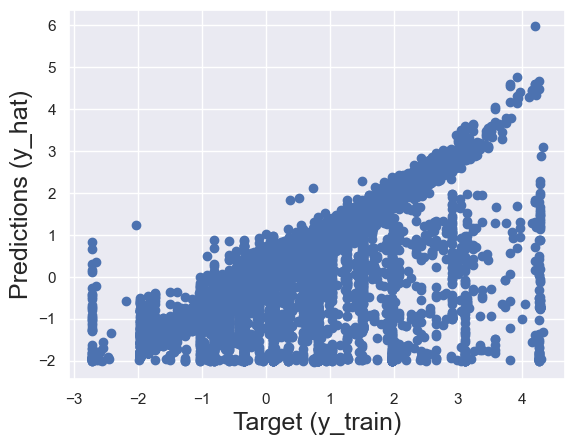

In [53]:
plt.scatter(y_train, y_hat)
plt.xlabel('Target (y_train)', size=18)
plt.ylabel('Predictions (y_hat)', size=18)
plt.show()

### Residual Plot

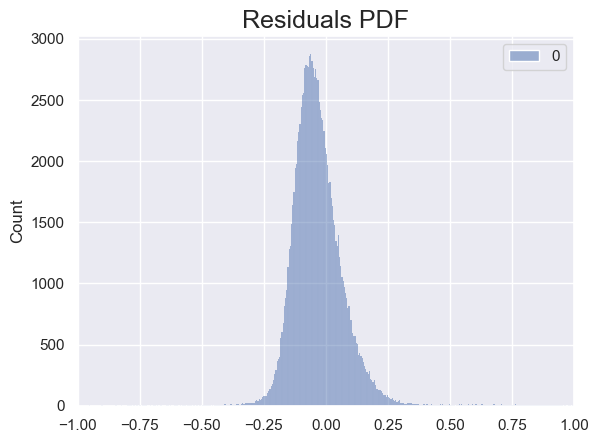

In [54]:
sns.histplot(y_train-y_hat)
plt.title('Residuals PDF', size=18)
plt.xlim(-1,1)
plt.show()

### Finding weights and bias

In [56]:
summary = pd.DataFrame(x.columns.values, columns=['Features'])
summary['weights'] = pd.DataFrame(np.array(reg.coef_).reshape(5, 1))
summary

,Features,weights
0,trip_duration,0.3894
1,distance_traveled,0.3064
2,num_of_passengers,-0.0017
3,tip,0.3498
4,miscellaneous_fees,0.2473


# Summary with StatModel

In [93]:
import statsmodels.api as sm
x = sm.add_constant(x_train)
results = sm.OLS(y_train, x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                 2.002e+05
Date:                Mon, 18 Dec 2023   Prob (F-statistic):               0.00
Time:                        20:10:12   Log-Likelihood:                -37868.
No. Observations:              122335   AIC:                         7.575e+04
Df Residuals:                  122329   BIC:                         7.581e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.001     -0.111      0.911      -0.002       0.002
x1             0.3894      0.001    259.674      0.000       0.386       0.392
x2             0.3064      0.002    200.279      0.000       0.303       0.309
x3            -0.0017      0.001     -1.810      0.070      -0.004       0.000
x4             0.3498      0.001    343.638      0.000       0.348       0.352
x5             0.2473      0.001    241.109      0.000       0.245       0.249
==============================================================================
Omnibus:                   182814.678   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         73844476.236
Skew:                           9.358   Prob(JB):                         0.00
Kurtosis:                     121.898   Cond. No.                         3.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Testing

In [57]:
y_hat_test = reg.predict(x_test)

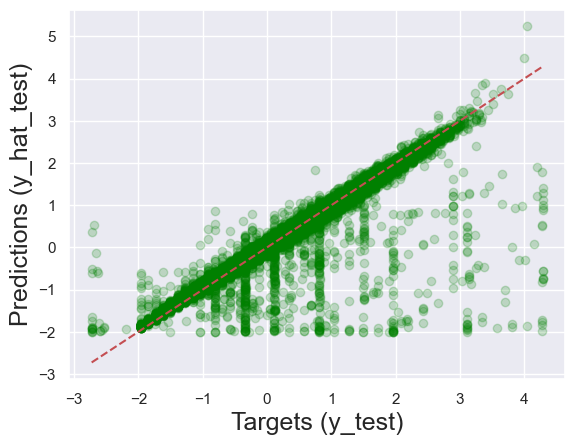

In [72]:
plt.scatter(y_test, y_hat_test, color='green', alpha=0.2)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Targets (y_test)', size=18)
plt.ylabel('Predictions (y_hat_test)', size=18)
#plt.axline([0, 0], [1, 1])
plt.show()

### Check predictions

In [74]:
df_new = pd.DataFrame(y_hat_test, columns=['Predictions'])
df_new.head()

,Predictions
0,-1.2565
1,-0.2095
2,-0.5332
3,-0.1311
4,1.9972


In [75]:
df_new['Targets'] = y_test
df_new.head()

,Predictions,Targets
0,-1.2565,-1.3863
1,-0.2095,-0.2895
2,-0.5332,-0.6936
3,-0.1311,-0.1163
4,1.9972,2.0195


In [77]:
df_new['Residuals'] = df_new['Targets'] - df_new['Predictions']
df_new.head()

,Predictions,Targets,Residuals
0,-1.2565,-1.3863,-0.1298
1,-0.2095,-0.2895,-0.0800
2,-0.5332,-0.6936,-0.1604
3,-0.1311,-0.1163,0.0148
4,1.9972,2.0195,0.0224


In [78]:
# Add absolute differences in percentage
df_new['Difference%'] = np.absolute(df_new['Residuals'] / df_new['Targets'] * 100)
df_new.head()

,Predictions,Targets,Residuals,Difference%
0,-1.2565,-1.3863,-0.1298,9.3662
1,-0.2095,-0.2895,-0.0800,27.6299
2,-0.5332,-0.6936,-0.1604,23.1234
3,-0.1311,-0.1163,0.0148,12.7071
4,1.9972,2.0195,0.0224,1.1068


We observed that the predictions are higher than the targets.

### Model Evaluation

In [180]:
print(f'Training Data R-squared: {reg.score(x_train, y_train):.4}')
print(f'Test Data R-squared: {reg.score(x_test, y_test):.4}')

Training Data R-squared: 0.8911
Test Data R-squared: 0.8924


In [181]:
print(f'Training Data MAE: {mean_absolute_error(y_train, y_hat):.4}')
print(f'Test Data MAE: {mean_absolute_error(y_test, y_hat_test):.4}')

Training Data MAE: 0.117
Test Data MAE: 0.1168


In [182]:
print(f'Training Data MSE: {mean_squared_error(y_train, y_hat):.4}')
print(f'Test Data MSE: {mean_squared_error(y_test, y_hat_test):.4}')

Training Data MSE: 0.1087
Test Data MSE: 0.1082


# Random Forest Regression

In [62]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

rf.fit(x_train, y_train)

RandomForestRegressor(random_state=42)

In [87]:
y_hat_rf = rf.predict(x_train)
y_hat_rf

array([ 1.68615097, -0.32875961,  0.40320465, ..., -0.80672997,
       -0.14865484, -0.34977184])

In [88]:
y_hat_rf_test = rf.predict(x_test)
y_hat_rf_test

array([-1.33636499, -0.19287287, -0.53772733, ..., -0.82520225,
       -1.47219401,  0.4260641 ])

In [89]:
print(f'Training Data R-squared: {rf.score(x_train, y_train):.4}')
print(f'Test Data R-squared: {rf.score(x_test, y_test):.4}')

Training Data R-squared: 0.9928
Test Data R-squared: 0.9581


In [90]:
print(f'Training Data MAE: {mean_absolute_error(y_train, y_hat_rf):.4}')
print(f'Test Data MAE: {mean_absolute_error(y_test, y_hat_rf_test):.4}')

Training Data MAE: 0.02324
Test Data MAE: 0.05925


In [91]:
print(f'Training Data MSE: {mean_squared_error(y_train, y_hat_rf):.4}')
print(f'Test Data MSE: {mean_squared_error(y_test, y_hat_rf_test):.4}')

Training Data MSE: 0.007149
Test Data MSE: 0.04214


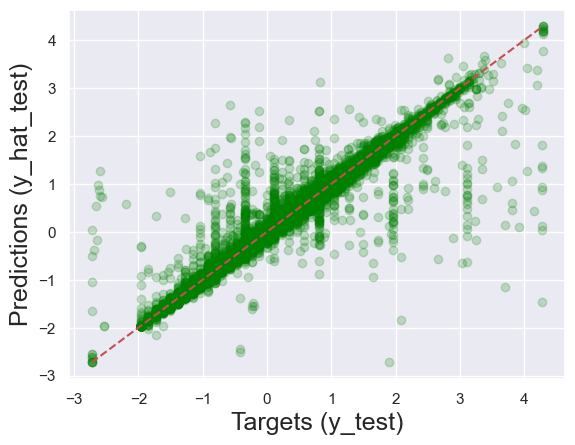

In [92]:
plt.scatter(y_test, y_hat_rf_test, color='green', alpha=0.2)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Targets (y_test)', size=18)
plt.ylabel('Predictions (y_hat_test)', size=18)
#plt.axline([0, 0], [1, 1])
plt.show()

The Random Forest seems to do slightly better.

# Artificial Neural Network

In [112]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

In [142]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(25, input_dim=5, activation='relu'), # 1st hidden layer
    tf.keras.layers.Dense(25, activation='relu'), # 2nd hidden layer
    tf.keras.layers.Dense(1, activation='linear') # output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# to stop training when the validation loss starts increasing, let's set patience=2
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

# fit the model
epochs_hist = model.fit(x_train,
          y_train,
          batch_size=100,
          epochs=100, # number of epochs that we will train for (assuming early stopping doesn't kick in)
          validation_split = 0.2,
          verbose = 2
          )  

Epoch 1/100
979/979 - 1s - loss: 0.1201 - val_loss: 0.0833 - 916ms/epoch - 936us/step
Epoch 2/100
979/979 - 1s - loss: 0.0741 - val_loss: 0.0644 - 555ms/epoch - 567us/step
Epoch 3/100
979/979 - 1s - loss: 0.0527 - val_loss: 0.0505 - 549ms/epoch - 561us/step
Epoch 4/100
979/979 - 1s - loss: 0.0487 - val_loss: 0.0493 - 551ms/epoch - 563us/step
Epoch 5/100
979/979 - 1s - loss: 0.0466 - val_loss: 0.0488 - 552ms/epoch - 564us/step
Epoch 6/100
979/979 - 1s - loss: 0.0459 - val_loss: 0.0480 - 601ms/epoch - 614us/step
Epoch 7/100
979/979 - 1s - loss: 0.0455 - val_loss: 0.0487 - 588ms/epoch - 601us/step
Epoch 8/100
979/979 - 1s - loss: 0.0449 - val_loss: 0.0477 - 551ms/epoch - 563us/step
Epoch 9/100
979/979 - 1s - loss: 0.0448 - val_loss: 0.0479 - 550ms/epoch - 562us/step
Epoch 10/100
979/979 - 1s - loss: 0.0441 - val_loss: 0.0462 - 551ms/epoch - 563us/step
Epoch 11/100
979/979 - 1s - loss: 0.0436 - val_loss: 0.0468 - 550ms/epoch - 562us/step
Epoch 12/100
979/979 - 1s - loss: 0.0436 - val_loss:

Epoch 96/100
979/979 - 1s - loss: 0.0377 - val_loss: 0.0386 - 553ms/epoch - 564us/step
Epoch 97/100
979/979 - 1s - loss: 0.0377 - val_loss: 0.0380 - 551ms/epoch - 563us/step
Epoch 98/100
979/979 - 1s - loss: 0.0376 - val_loss: 0.0377 - 550ms/epoch - 562us/step
Epoch 99/100
979/979 - 1s - loss: 0.0374 - val_loss: 0.0384 - 562ms/epoch - 574us/step
Epoch 100/100
979/979 - 1s - loss: 0.0377 - val_loss: 0.0394 - 552ms/epoch - 564us/step


### Visualize the loss

In [144]:
epochs_hist.history.keys()

dict_keys(['loss', 'val_loss'])

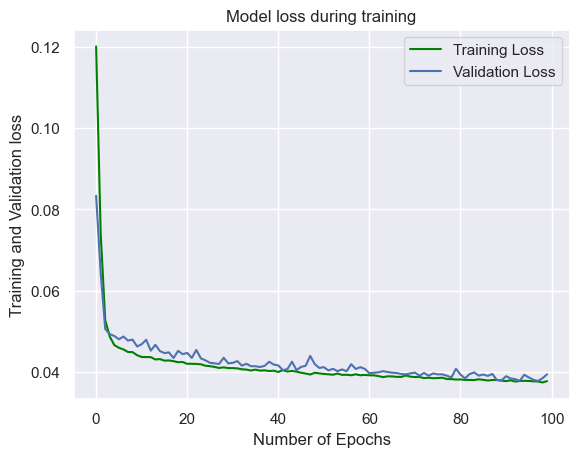

In [145]:
plt.plot(epochs_hist.history['loss'], color='green')
plt.plot(epochs_hist.history['val_loss'])
plt.title('Model loss during training')
plt.ylabel('Training and Validation loss')
plt.xlabel('Number of Epochs')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

From the graph above, we can use 40 epochs.

In [146]:
# Extract the last weights in training
model.layers[2].get_weights()

[array([[ 0.09131874],
        [ 0.43974116],
        [-0.9389036 ],
        [-0.42974064],
        [-0.15764184],
        [-0.18710296],
        [ 0.1161923 ],
        [ 0.76063085],
        [ 1.1759976 ],
        [-0.08456559],
        [-0.30993792],
        [-0.21968438],
        [ 0.3295796 ],
        [ 0.7575103 ],
        [-0.04170616],
        [-0.2579991 ],
        [-0.31279877],
        [ 0.27713686],
        [ 0.09158963],
        [-0.05507903],
        [ 0.11657508],
        [-0.06242879],
        [ 0.08356822],
        [ 0.27300954],
        [ 0.18635102]], dtype=float32),
 array([-0.34009045], dtype=float32)]

In [147]:
# Extract the last bias in training
bias = model.layers[2].get_weights()[1]
bias

array([-0.34009045], dtype=float32)

### Test the model

In [151]:
test_loss = model.evaluate(x_test, y_test)

956/956 [==============================] - 0s 378us/step - loss: 0.0412


# Making predictions

## Question
Given that there are two passengers on a trip with a trip duration of 100 minutes, a distance traveled of 5 miles, a tip of 10, and miscellaneous fees of 5, what will be their total fare?

In [152]:
new_data = np.array([[100, 5, 2, 10, 5]])
prediction1 = model.predict(x_test_data)

1/1 [==============================] - 0s 38ms/step


In [153]:
print('Expected Total Fare:', prediction1)

Expected Total Fare: [[54.25253]]


Based on the model, I expect the total fare to be $54.00